In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns  
from collections import Counter
import csv
import itertools
import nltk

### LOAD THE DATA

In [2]:
data = pd.read_csv('CrowdstormingDataJuly1st.csv',sep=",")

In [3]:
data.shape

(146028, 28)

### REMARKS ABOUT THE DATASET

- Our data consist of interactions between players and referees in the 4 major leagues
- Since we will predict the skin color at first hand then ratings will be our labels
- The ratings are imbalanced toward white people
- It happens that both raters disagree on the skin color of a player
- playerShort is the unique name player so we will be using it
- Some players are not rated by raters (NaN) Those will be removed. Those players correspond to player for which there is no photo ID.
- Some players have more than two names (3 or 4 tokens)

### IDEA OF THE TREATMENT

- We noticed that in very few cases (3) both raters disagree by 0.5 or more. Thus, we decided to keep them.
- To manage disagreements in both raters, we decided to average them. Therefore, we will create 4 new classes resulting in a total of 9 classes
- For simplicity, we will fit 2 class labels to our classifier (greater or smaller than 0.5).
- We decided to keep some common player first/last names since it could be informative of the skin color of a particular player
- We decided to groupby the unique name of players (since we don't want to predict the skin color of the same player many times) and to sum all the player-games related features (redCards,...) and divide them by the total number of games. However, since players encountered many referees, how to use features related to the referees that interacted with each player ?
- That's why, we decided to classify the referees into three categories with regard to their country of origin. Indeed, we use meanExp and meanIAT after standardizing and averaging them, that way each referee will be classified as one of the three categories : 1/ Referee country correspond to greater feelings of warmth toward whites versus blacks , 2/ Referee country Neutral, 3/ Referee country correspond to lesser feelings of warmth toward whites versus blacks
- We will now groupby the unique player name AND the referee category and sum over all the player-game related features and divide them by the total number of games in each category.
- Finally we pivot (which will create new features) and feed the model.

### MAJOR PROBLEM WITH THE ANALYSIS : IMBALANCE OF THE DATASET

- We noticed that the dataset is biased toward white people (75.7% for whites and 24.3 for blacks)
- Therefore, if we fit a supervised learning model to our data, we will end up with predictions highly biased.
- We will discuss below the solutions we have found to deal with this problem

# EXPLANATORY DATA ANALYSIS

In [4]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


- The plot below shows us that there is a clear imbalance of the dataset
- more than 75% of ratings are biased toward white people

(array([ 35712.,  56483.,  12650.,   9915.,   9861.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 5 Patch objects>)

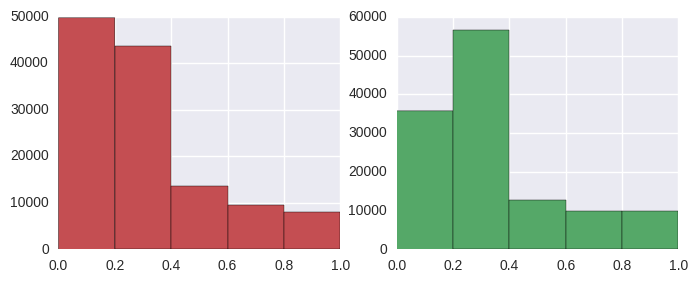

In [5]:
c = sns.color_palette()
fig, ax = plt.subplots(1,2,figsize=(8, 3))
ax[0].hist(data['rater1'],bins = 5, range = (0,1),color = c[2])
ax[1].hist(data['rater2'],bins = 5, range = (0,1),color = c[1])

# Cleaning 

- Removing all NaN values in the ratings
- Around 20000 entries

In [6]:
data=data[(pd.isnull(data["rater1"])==False) & (pd.isnull(data["rater2"])==False)]

In [7]:
data.shape

(124621, 28)

## DEALING WITH THE PLAYERS NAME

- Here we decided to keep the 60 most common first/last names

In [8]:
nNames = 60
uncommon_name = "UNCOMMON"

In [9]:
names=data['player'].unique()

- Tokenizing

In [10]:
tokenizedNames = [nltk.word_tokenize(name) for name in names]

- nameFreq is a dictionary of each token with values the number of times it appeared in tokenizedNames

In [11]:
nameFreq = nltk.FreqDist(itertools.chain(*tokenizedNames))

- commonNames: Taking most 60 common names with the number of appearance
- nameToIndex : dictionary of indexes of each most common name

In [12]:
commonNames = nameFreq.most_common(nNames-1)
indexToName = [x[0] for x in commonNames]
indexToName.append(uncommon_name)
nameToIndex = dict([(n,i) for i,n in enumerate(indexToName)])

- tokenizedNames list of list for each player with common and uncommon tokens (name)

In [13]:
for i, name in enumerate(tokenizedNames):
    tokenizedNames[i] = [n if n in nameToIndex else uncommon_name for n in name]

- Creating a dictionary with most common names as keys and frequency as values

In [14]:
n_name={}

In [15]:
for x in commonNames:
    n_name[x[0]]=x[1]

In [16]:
n_name[""]=0

In [17]:
players=data['player'].tolist()

In [18]:
players=[players[i].split(' ') for i in range(len(players))]

- Creating a new feature with the index of most common names and 0 for the others

In [19]:
players_index=[]

In [20]:
for i in range(len(players)):
    if players[i][0] in nameToIndex.keys():
        k=nameToIndex[players[i][0]]+1
        name=players[i][0]
    else:
        k=0
        name=""
    for j in range(1,len(players[i])):
        if players[i][j] in nameToIndex.keys() and n_name[name]<n_name[players[i][j]]:
            k=nameToIndex[players[i][j]]+1
            name=players[i][j]
    players_index.append(k)

In [21]:
data['player']=players_index

## keeping the birthyear

- We decided to keep the birth years of the players

In [22]:
birth=data['birthday'].str.split('.').tolist()

In [23]:
x=[]
for i in range(len(birth)):    
    x.append(int(birth[i][2]))

In [24]:
data['birthday']=x

In [25]:
data.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,37,Real Zaragoza,Spain,1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,14,Montpellier HSC,France,1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,0,Fulham FC,England,1979,182.0,71.0,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,0,Manchester City,England,1985,187.0,80.0,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,10,Norwich City,England,1986,180.0,68.0,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


# REPLACE EACH STRING COLUMN BY ITS INDEXES

## leagueCountry

- Here we encode all strings to feed them to the random forest model.

In [26]:
y=[]
for x in data['leagueCountry']:
    if x=='Spain':
        y.append(1)
    if x=='England':
        y.append(2)
    if x=='France':
        y.append(3)
    if x=='Germany':
        y.append(4)

In [27]:
data['leagueCountry']=y

## club

- Indexing the club names

In [28]:
club=data['club'].unique()

In [29]:
club_to_index=dict([(w,i) for i,w in enumerate(club)])

In [30]:
z=[]
for x in data['club']:
    z.append(club_to_index[x])

In [31]:
z+=np.add(z,1)
z

array([  1,   3,   5, ..., 115,  19, 109])

In [32]:
data['club']=z

## position

- indexing the positions

In [33]:
position=data['position'].unique()

In [34]:
position_to_index=dict([(w,i) for i,w in enumerate(position)])

In [35]:
z=[]
for x in data['position']:
    z.append(position_to_index[x])

In [36]:
z+=np.add(z,1)

In [37]:
data['position']=z

In [38]:
data.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

## DEALING WITH THE AGGREG

## BUILDING THE X MATRIX

#### ALL FEATURES RELATED TO THE PLAYER ONLY

In [39]:
dataPlayer=data[['playerShort','player','club','leagueCountry','birthday','height','weight','position','rater1','rater2']]

In [40]:
dataPlayer=dataPlayer.drop_duplicates()
dataPlayer=dataPlayer.reset_index()

In [41]:
dataPlayer=dataPlayer.drop('index',axis=1)

In [42]:
dataPlayer.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,rater1,rater2
0,lucas-wilchez,37,1,1,1983,177.0,72.0,1,0.25,0.50
1,john-utaka,14,3,3,1982,179.0,82.0,3,0.75,0.75
2,aaron-hughes,0,5,2,1979,182.0,71.0,5,0.25,0.00
3,aleksandar-kolarov,0,7,2,1985,187.0,80.0,7,0.00,0.25
4,alexander-tettey,10,9,2,1986,180.0,68.0,9,1.00,1.00


- Filling the missing values by the mean

In [43]:
dataPlayer=dataPlayer.fillna(dataPlayer.mean())

- dropping the playerShort because it is equivalent to the index

In [44]:
dataPlayer=dataPlayer.drop('playerShort',axis=1)

In [45]:
dataPlayer.head()

,player,club,leagueCountry,birthday,height,weight,position,rater1,rater2
0,37,1,1,1983,177.0,72.0,1,0.25,0.50
1,14,3,3,1982,179.0,82.0,3,0.75,0.75
2,0,5,2,1979,182.0,71.0,5,0.25,0.00
3,0,7,2,1985,187.0,80.0,7,0.00,0.25
4,10,9,2,1986,180.0,68.0,9,1.00,1.00


- Averaging the ratings : creating a new response with the average of both raters

In [46]:
dataPlayer['rater']=(dataPlayer['rater1']+dataPlayer['rater2'])/2

In [47]:
dataPlayer=dataPlayer.drop(['rater1','rater2'],axis=1)

In [48]:
dataPlayer.head()

,player,club,leagueCountry,birthday,height,weight,position,rater
0,37,1,1,1983,177.0,72.0,1,0.375
1,14,3,3,1982,179.0,82.0,3,0.750
2,0,5,2,1979,182.0,71.0,5,0.125
3,0,7,2,1985,187.0,80.0,7,0.125
4,10,9,2,1986,180.0,68.0,9,1.000


In [49]:
playerMat=dataPlayer.as_matrix()

- playerMat will be then the matrix related to the player

In [50]:
columns=np.asarray(dataPlayer.columns)[:dataPlayer.shape[1]-1]

## data REFEREE

- Dealing with referee related features

In [51]:
dataRef=data[['refNum','refCountry','meanIAT','meanExp']]

In [52]:
dataRef.head()

,refNum,refCountry,meanIAT,meanExp
0,1,1,0.326391,0.396000
1,2,2,0.203375,-0.204082
5,4,4,0.325185,0.538462
6,4,4,0.325185,0.538462
7,4,4,0.325185,0.538462


In [53]:
dataRef=dataRef.drop_duplicates()
dataRef=dataRef.reset_index()

In [54]:
dataRef=dataRef.drop('index',axis=1)

In [55]:
dataRef.head()

,refNum,refCountry,meanIAT,meanExp
0,1,1,0.326391,0.396000
1,2,2,0.203375,-0.204082
2,4,4,0.325185,0.538462
3,6,6,0.322177,0.117647
4,7,7,0.334684,0.336101


- standardizing both meanIAT and meanEXP

In [56]:
dataRef['meanIAT']=(dataRef['meanIAT']-np.mean(dataRef['meanIAT']))/np.std(dataRef['meanIAT'])

In [57]:
dataRef['meanExp']=(dataRef['meanExp']-np.mean(dataRef['meanExp']))/np.std(dataRef['meanExp'])

- We create a new feature : indicator which indicates the racism in referee country of origin

In [58]:
dataRef['indicator']=(dataRef['meanExp']+dataRef['meanIAT'])/2

- We drop them since we already used them in the creation of indicator

In [59]:
dataRef=dataRef.drop('meanIAT',axis=1)
dataRef=dataRef.drop('meanExp',axis=1)

- As discussed in the "IDEA OF THE TREATMENT", we define three categories for referees depending on the indicator of racism in their country of origin 
- We selected the threshold in such a way to have approximately the same number of referees at the tails.

In [60]:
dataRef[dataRef['indicator']<-1.5]['refCountry'].unique().shape

(34,)

In [61]:
dataRef[dataRef['indicator']>0.5]['refCountry'].unique().shape

(33,)

In [62]:
dataRef[(dataRef['indicator']>=-1.5) & (dataRef['indicator']<=0.5)]['refCountry'].unique().shape

(88,)

- There are five country's for which we have no indicator
- For those country's we decided to put them in the middle class

In [63]:
dataRef[dataRef['indicator'].isnull()]['refCountry'].unique().shape

(5,)

In [64]:
dataRef['refCountry'].unique().shape

(160,)

- We define a new feature typeCountry which puts every referee in one of the three classes :
- 1/ Referee country correspond to greater feelings of warmth toward whites versus blacks , 2/ Referee country Neutral, 3/ Referee country correspond to lesser feelings of warmth toward whites versus blacks

In [65]:
dataRef['typeCountry']=[1 if x<-1.5 else 3 if (x>0.5) else 2 for x in dataRef['indicator']]

In [66]:
dataRef.head()

,refNum,refCountry,indicator,typeCountry
0,1,1,-0.297311,2
1,2,2,-2.303716,1
2,4,4,-0.107207,2
3,6,6,-0.730604,2
4,7,7,-0.303969,2


In [67]:
dataRef=dataRef.drop('indicator',axis=1)
dataRef=dataRef.drop('refCountry',axis=1)

In [68]:
dataRef.head()

,refNum,typeCountry
0,1,2
1,2,1
2,4,2
3,6,2
4,7,2


In [69]:
refNumType={}
for i in range(dataRef.shape[0]):
    refNumType[dataRef['refNum'][i]]=dataRef['typeCountry'][i]

#### PLAYER-REFEREE

In [70]:
data.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

- Dealing with all the features of the interaction player-referee

In [71]:
dataPlayerRef=data[['playerShort','games','victories','ties','defeats','goals','yellowCards', 'yellowReds', 'redCards','refNum']]

In [72]:
dataPlayerRef.head()

,playerShort,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refNum
0,lucas-wilchez,1,0,0,1,0,0,0,0,1
1,john-utaka,1,0,0,1,0,1,0,0,2
5,aaron-hughes,1,0,0,1,0,0,0,0,4
6,aleksandar-kolarov,1,1,0,0,0,0,0,0,4
7,alexander-tettey,1,0,0,1,0,0,0,0,4


In [73]:
dataPlayerRef=dataPlayerRef.reset_index()
dataPlayerRef=dataPlayerRef.drop('index',axis=1)

- Appending the category of each referee (typeCountry)

In [74]:
typeCountry=[]
for i in range(dataPlayerRef.shape[0]):
    typeCountry.append(refNumType[dataPlayerRef['refNum'][i]])

- Adding the category of each referee to the dataframe

In [75]:
dataPlayerRef['typeCountry']=typeCountry

- We then drop the referee number, since we have to which category it belongs.

In [76]:
dataPlayerRef=dataPlayerRef.drop('refNum',axis=1)

In [77]:
dataPlayerRef.head()

,playerShort,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,typeCountry
0,lucas-wilchez,1,0,0,1,0,0,0,0,2
1,john-utaka,1,0,0,1,0,1,0,0,1
2,aaron-hughes,1,0,0,1,0,0,0,0,2
3,aleksandar-kolarov,1,1,0,0,0,0,0,0,2
4,alexander-tettey,1,0,0,1,0,0,0,0,2


- As discussed in the "IDEA OF THE TREATMENT", we finally groupby the unique player name and the category(typeCountry)

In [78]:
PlayerRef_grouped=dataPlayerRef.groupby(['playerShort','typeCountry'])

- We sum over all the player-referee related features by category

In [79]:
PlayerRef_grouped=PlayerRef_grouped.sum()

In [80]:
PlayerRef_grouped.head()

games  victories  ties  defeats  goals  yellowCards  \
playerShort  typeCountry                                                        
aaron-hughes 2              626        234   173      219      8           18   
             3               28         13     6        9      1            1   
aaron-hunt   2              323        134    70      119     61           39   
             3               13          7     3        3      1            3   
aaron-lennon 2              391        185    92      114     31           10   

                          yellowReds  redCards  
playerShort  typeCountry                        
aaron-hughes 2                     0         0  
             3                     0         0  
aaron-hunt   2                     0         1  
             3                     0         0  
aaron-lennon 2                     0         0

In [81]:
PlayerRef_grouped=PlayerRef_grouped.reset_index()

In [82]:
PlayerRef_grouped.head()

,playerShort,typeCountry,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
0,aaron-hughes,2,626,234,173,219,8,18,0,0
1,aaron-hughes,3,28,13,6,9,1,1,0,0
2,aaron-hunt,2,323,134,70,119,61,39,0,1
3,aaron-hunt,3,13,7,3,3,1,3,0,0
4,aaron-lennon,2,391,185,92,114,31,10,0,0


- We then divide by the number of games 

In [83]:
PlayerRef_grouped['victories']=PlayerRef_grouped['victories'].div(PlayerRef_grouped['games'],axis=0)

In [84]:
PlayerRef_grouped['ties']=PlayerRef_grouped['ties'].div(PlayerRef_grouped['games'],axis=0)

In [85]:
PlayerRef_grouped['defeats']=PlayerRef_grouped['defeats'].div(PlayerRef_grouped['games'],axis=0)

In [86]:
PlayerRef_grouped['goals']=PlayerRef_grouped['goals'].div(PlayerRef_grouped['games'],axis=0)

In [87]:
PlayerRef_grouped['yellowCards']=PlayerRef_grouped['yellowCards'].div(PlayerRef_grouped['games'],axis=0)

In [88]:
PlayerRef_grouped['yellowReds']=PlayerRef_grouped['yellowReds'].div(PlayerRef_grouped['games'],axis=0)

In [89]:
PlayerRef_grouped['redCards']=PlayerRef_grouped['redCards'].div(PlayerRef_grouped['games'],axis=0)

In [90]:
PlayerRef_grouped.head()

,playerShort,typeCountry,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards
0,aaron-hughes,2,626,0.373802,0.276358,0.349840,0.012780,0.028754,0.0,0.000000
1,aaron-hughes,3,28,0.464286,0.214286,0.321429,0.035714,0.035714,0.0,0.000000
2,aaron-hunt,2,323,0.414861,0.216718,0.368421,0.188854,0.120743,0.0,0.003096
3,aaron-hunt,3,13,0.538462,0.230769,0.230769,0.076923,0.230769,0.0,0.000000
4,aaron-lennon,2,391,0.473146,0.235294,0.291560,0.079284,0.025575,0.0,0.000000


- we pivot to create new features : for each interaction player-"refereecategory" we will have a group of features :
- for instance : "proportion of redCards given by category 1","proportion ofredCards given by category 2","proportion redCards given by category 1" ...

In [91]:
PlayerRef_grouped=PlayerRef_grouped.pivot("playerShort","typeCountry")

In [92]:
PlayerRef_grouped=PlayerRef_grouped.drop('games',axis=1)

In [93]:
PlayerRef_grouped.head()

victories                          ties            \
typeCountry                    1         2         3         1         2   
playerShort                                                                
aaron-hughes                 NaN  0.373802  0.464286       NaN  0.276358   
aaron-hunt                   NaN  0.414861  0.538462       NaN  0.216718   
aaron-lennon                 NaN  0.473146  0.714286       NaN  0.235294   
aaron-ramsey                 NaN  0.591667  0.400000       NaN  0.166667   
abdelhamid-el-kaoutari  0.333333  0.327731  0.500000  0.666667  0.310924   

                                 defeats                     goals ...   \
typeCountry                    3       1         2         3     1 ...    
playerShort                                                        ...    
aaron-hughes            0.214286     NaN  0.349840  0.321429   NaN ...    
aaron-hunt              0.230769     NaN  0.368421  0.230769   NaN ...    
aaron-lennon            0.238095     NaN  0.291560  0.047619   NaN ...    
aaron-ramsey            0.100000     NaN  0.241667  0.500000   NaN ...    
abdelhamid-el-kaoutari  0.500000     0.0  0.361345  0.000000   0.0 ...    

                                 yellowCards                     yellowReds  \
typeCountry                    3           1         2         3          1   
playerShort                                                                   
aaron-hughes            0.035714         NaN  0.028754  0.035714        NaN   
aaron-hunt              0.076923         NaN  0.120743  0.230769        NaN   
aaron-lennon            0.000000         NaN  0.025575  0.047619        NaN   
aaron-ramsey            0.200000         NaN  0.120833  0.100000        NaN   
abdelhamid-el-kaoutari  0.000000         0.0  0.067227  0.000000        0.0   

                                      redCards                 
typeCountry                    2    3        1         2    3  
playerShort                                                    
aaron-hughes            0.000000  0.0      NaN  0.000000  0.0  
aaron-hunt              0.000000  0.0      NaN  0.003096  0.0  
aaron-lennon            0.000000  0.0      NaN  0.000000  0.0  
aaron-ramsey            0.000000  0.0      NaN  0.004167  0.0  
abdelhamid-el-kaoutari  0.033613  0.0      0.0  0.016807  0.0  

[5 rows x 21 columns]

- We fill the missing values by the mean

In [94]:
PlayerRef_grouped=PlayerRef_grouped.fillna(PlayerRef_grouped.mean())

In [95]:
playerRef=PlayerRef_grouped.as_matrix()

In [96]:
playerRef.shape

(1585, 21)

## GROUPING ALL TOGETHER

- here we group all the parts we did before

- Here we store the response variable and then remove it from the matrix

In [97]:
Y=playerMat[:,7]

In [98]:
playerMat=np.delete(playerMat,7,axis=1)

- stacking :

In [99]:
X=np.column_stack((playerMat,playerRef))

In [100]:
columns=np.concatenate((columns,np.asarray(PlayerRef_grouped.columns.levels[0][1:])+'_1',
                        np.asarray(PlayerRef_grouped.columns.levels[0][1:])+'_2',
                        np.asarray(PlayerRef_grouped.columns.levels[0][1:])+'_3'))

- Below, you can find all of our features that we will feed to the random foret classifier

In [101]:
columns

array(['player', 'club', 'leagueCountry', 'birthday', 'height', 'weight',
       'position', 'victories_1', 'ties_1', 'defeats_1', 'goals_1',
       'yellowCards_1', 'yellowReds_1', 'redCards_1', 'victories_2',
       'ties_2', 'defeats_2', 'goals_2', 'yellowCards_2', 'yellowReds_2',
       'redCards_2', 'victories_3', 'ties_3', 'defeats_3', 'goals_3',
       'yellowCards_3', 'yellowReds_3', 'redCards_3'], dtype=object)

# SUPERVISED LEARNING : RANDOM FOREST CLASSIFIER

In [102]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix

## IMBALANCE ISSUE :

- We will fit our model with two classes

In [103]:
Y_true=(Y>=0.5).astype(int)

In [104]:
Counter(Y_true)

Counter({0: 1200, 1: 385})

In [105]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

- From the counter of Y_true, we can see that our two classes are imbalanced (order of 3) which is not that big
- Acutally from here, we can expect that the Random forest classifier will give us decent results (robust to the imbalance)
- it exist a parameter in the random forest classifier : class_weight which associates different weights to different categories to penalize the biggest classes over the lowest ones.
- We will try this parameter with different weights
- We have two metrics that are widela used : 1/ Accuracy : the ratio of correctly predicted observations 2/Recall : TP/(TP+FN) 3/ Precision : TP/(TP+FP) 4/f1score : 2 x Recall x Precision/(Recall+Precision)
- We will be showing confusion matrix and the classification report with all those metrics. However we will focus on the f1 score since it combines both recall and precision

- Below, we can see that the accuracy score is quite high while other scores are very low and that's why we can't only use one metric
- this is due to the imbalance

In [106]:
RFC=RandomForestClassifier()
print('Accuracy : ',np.mean(cross_val_score(RFC,X,Y_true,cv=20,scoring='accuracy')))
print('Precision : ',np.mean(cross_val_score(RFC,X,Y_true,cv=20,scoring='precision')))
print('Recall : ',np.mean(cross_val_score(RFC,X,Y_true,cv=20,scoring='recall')))
print('F1-score : ',np.mean(cross_val_score(RFC,X,Y_true,cv=20,scoring='f1')))
print('ROC AUC : ',np.mean(cross_val_score(RFC,X,Y_true,cv=20,scoring='roc_auc')))

Accuracy :  0.741392405063


/home/zaafr4ne/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision :  0.419107142857
Recall :  0.0882894736842
F1-score :  0.157050713566
ROC AUC :  0.569150219298


Confusion matrix, without normalization
[[292  17]
 [ 82   6]]
Normalized confusion matrix
[[ 0.94  0.06]
 [ 0.93  0.07]]


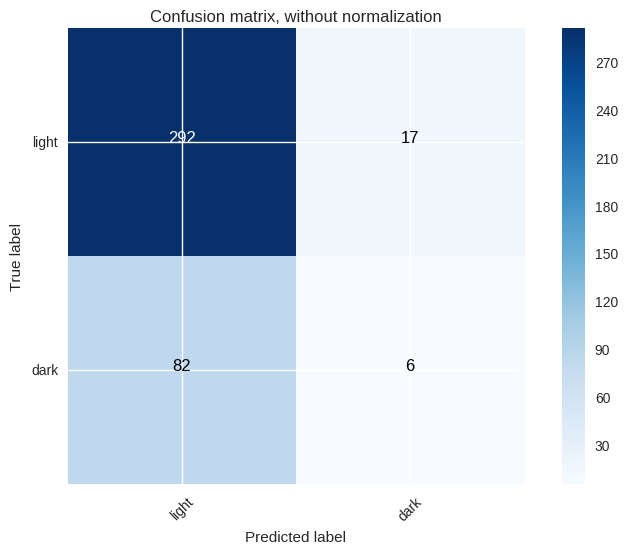

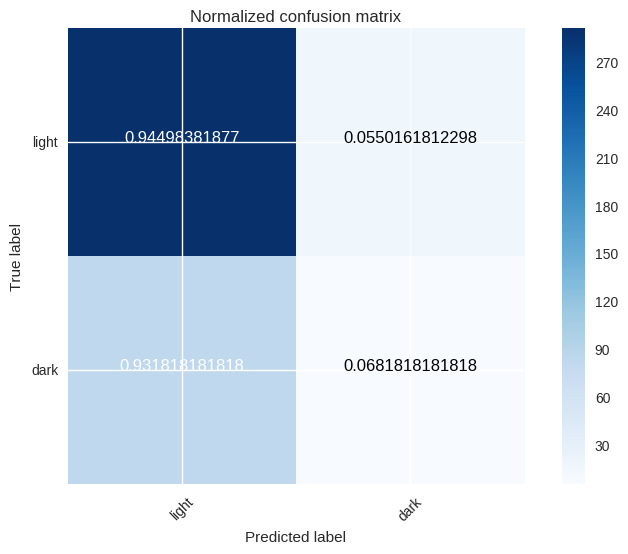

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_true, random_state=0)
y_pred = RFC.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names=['light','dark']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

- To deal with the imbalance of the dataset, we will use the parameter class_weight of the random forest classifier

In [108]:
weighted_RFC=RandomForestClassifier(class_weight='balanced')
print('Accuracy : ',np.mean(cross_val_score(weighted_RFC,X,Y_true,cv=20,scoring='accuracy')))
print('Precision : ',np.mean(cross_val_score(weighted_RFC,X,Y_true,cv=20,scoring='precision')))
print('Recall : ',np.mean(cross_val_score(weighted_RFC,X,Y_true,cv=20,scoring='recall')))
print('F1-score : ',np.mean(cross_val_score(weighted_RFC,X,Y_true,cv=20,scoring='f1')))
print('ROC AUC : ',np.mean(cross_val_score(weighted_RFC,X,Y_true,cv=20,scoring='roc_auc')))

Accuracy :  0.754018987342
Precision :  0.39625
Recall :  0.0886842105263
F1-score :  0.13681724073
ROC AUC :  0.577471491228


Confusion matrix, without normalization
[[294  15]
 [ 83   5]]
Normalized confusion matrix
[[ 0.95  0.05]
 [ 0.94  0.06]]


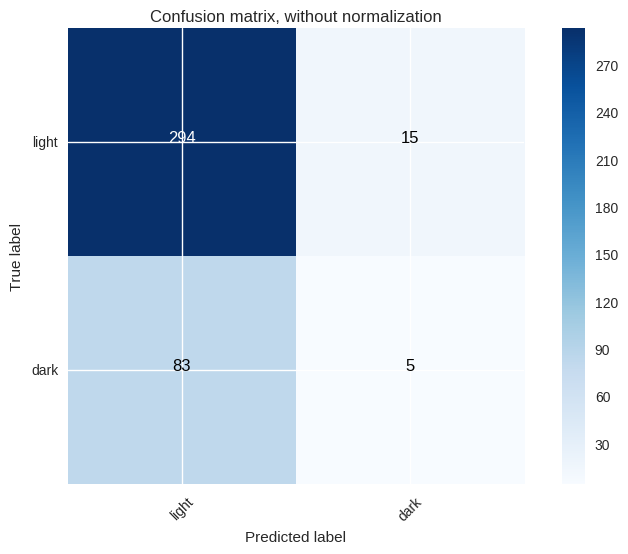

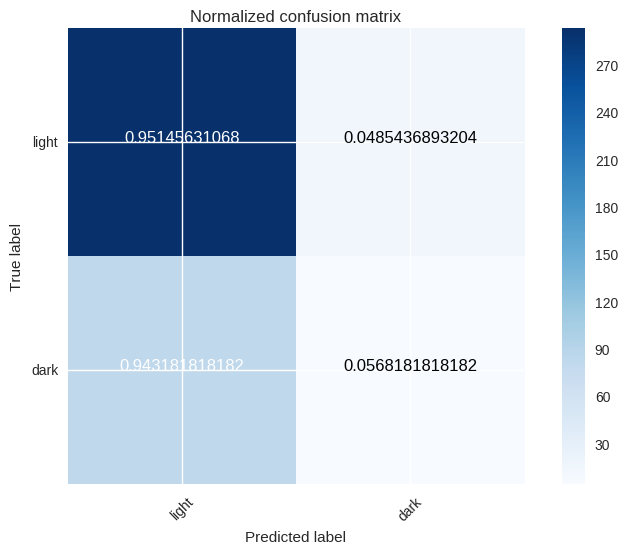

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_true, random_state=0)
y_pred = weighted_RFC.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names=['light','dark']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

- We tried many weights for the class_weight parameter, but it doesn't improve the scores.
- Another method is to use different thresholds with the output probabilities :

- below, we try different threshold values and output the f1-score

In [110]:
ths=np.linspace(0.5,0.9,9)
for th in ths:
    RFC=RandomForestClassifier(n_estimators=30)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_true, test_size=0.2)
    RFC.fit(X_train,Y_train)
    y_pred=RFC.predict_proba(X_test)
    y_pred=y_pred[:,0]
    y_pred_=(y_pred<=th).astype(int)
    print('threshold =', th,'gives F1-score =', f1_score(Y_test, y_pred_,average='binary'))

threshold = 0.5 gives F1-score = 0.16091954023
threshold = 0.55 gives F1-score = 0.217821782178
threshold = 0.6 gives F1-score = 0.338235294118
threshold = 0.65 gives F1-score = 0.464788732394
threshold = 0.7 gives F1-score = 0.427860696517
threshold = 0.75 gives F1-score = 0.408695652174
threshold = 0.8 gives F1-score = 0.362369337979
threshold = 0.85 gives F1-score = 0.422960725076
threshold = 0.9 gives F1-score = 0.4327176781


- We can see a significant improvement after changing the thresholds.
- However we decided to use the under sampling method because it gives us good scores as you can see below :
- We create new X_resampled matrix and reponse matrix Y_resampled

In [111]:
random_indices=np.concatenate((np.random.choice(np.where(Y_true==0)[0],np.where(Y_true==1)[0].shape[0]),np.where(Y_true==1)[0]))
Y_resampled=Y_true[random_indices]
X_resampled=X[random_indices,:]
Counter(Y_resampled)

Counter({0: 385, 1: 385})

In [112]:
resampled_RFC=RandomForestClassifier()
print('Accuracy : ',np.mean(cross_val_score(weighted_RFC,X_resampled,Y_resampled,cv=20,scoring='accuracy')))
print('Precision : ',np.mean(cross_val_score(weighted_RFC,X_resampled,Y_resampled,cv=20,scoring='precision')))
print('Recall : ',np.mean(cross_val_score(weighted_RFC,X_resampled,Y_resampled,cv=20,scoring='recall')))
print('F1-score : ',np.mean(cross_val_score(weighted_RFC,X_resampled,Y_resampled,cv=20,scoring='f1')))
print('ROC AUC : ',np.mean(cross_val_score(weighted_RFC,X_resampled,Y_resampled,cv=20,scoring='roc_auc')))

Accuracy :  0.612894736842
Precision :  0.624408503863
Recall :  0.503289473684
F1-score :  0.557291901166
ROC AUC :  0.647157548476


Confusion matrix, without normalization
[[75 25]
 [49 44]]
Normalized confusion matrix
[[ 0.75  0.25]
 [ 0.53  0.47]]


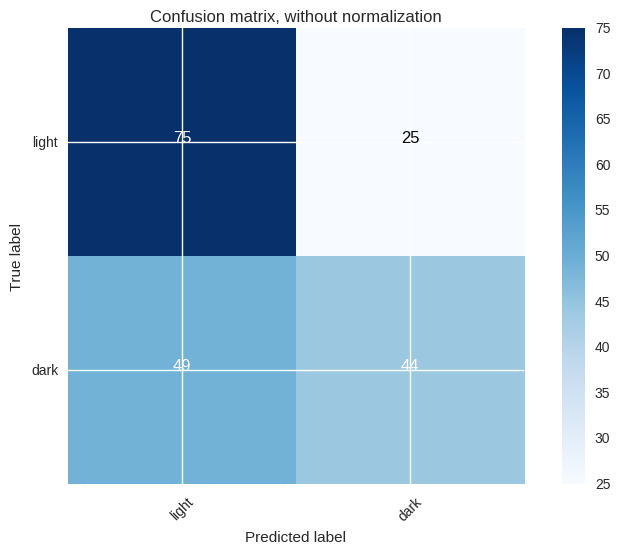

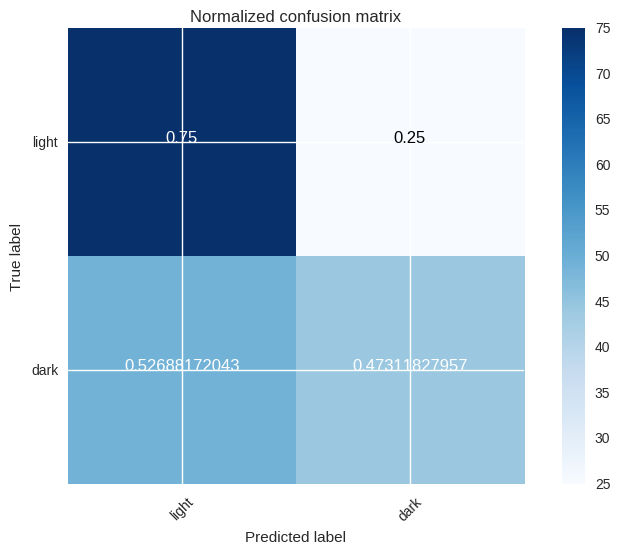

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, random_state=0)
y_pred = resampled_RFC.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names=['light','dark']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

- We find acceptable scores with this method even if we don't use all of the data at our disposal.

## OVERFITTING ISSUE

- Here we will deal with the overfitting issue with the different parameters
- Beforehand, we will look at the influence of each parameter over the overfitting
- we will try by the n_estimators paramter :

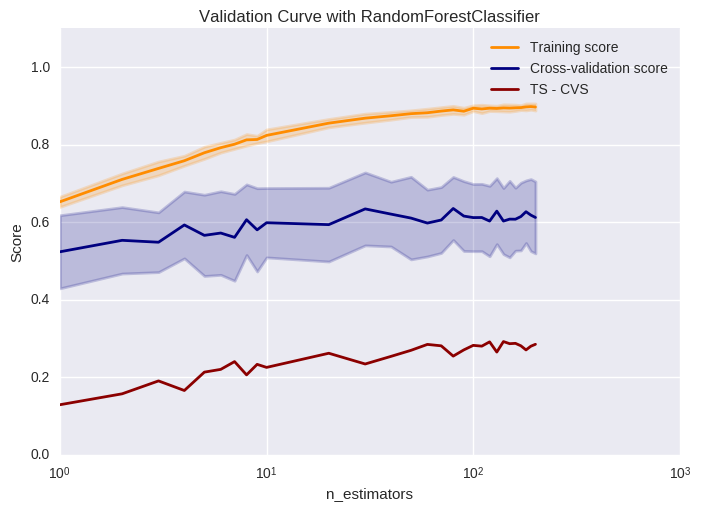

In [114]:
#param_range = np.arange(1,5)
param_range=np.concatenate((np.arange(1,10),np.arange(1,21)*10))
train_scores, test_scores = validation_curve(
    RandomForestClassifier(min_samples_leaf=10), X_resampled, Y_resampled, param_name="n_estimators", param_range=param_range,
    cv=30, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.semilogx(param_range, train_scores_mean-test_scores_mean, label="TS - CVS",
             color="darkred", lw=lw)

plt.legend(loc="best")
plt.show()

- With the plot above we can see that the parameter n_estimator affect the overfitting.
- In fact when we fit the model using default parameters we get a training accuracy too high from the start (doesn't let us make any conclusions), that's why we chose to put min_samples_leaf=10 to let the training accuracy increase.
- Now, we take a look at the max_features parameter

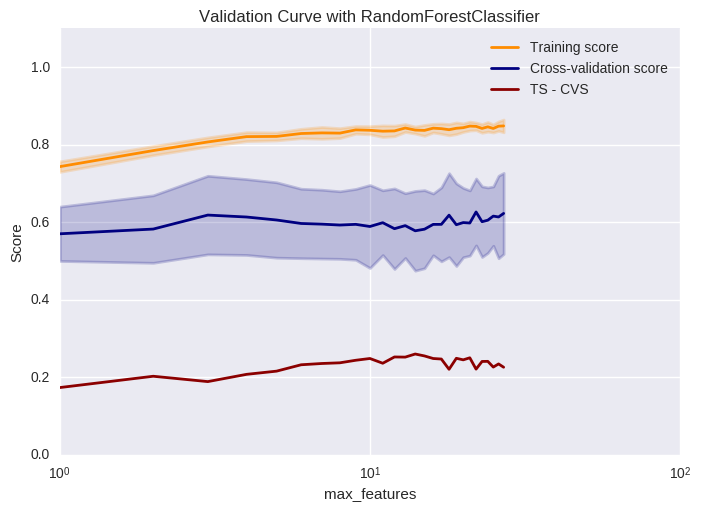

In [115]:
param_range = np.arange(1,28)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(min_samples_leaf=10), X_resampled, Y_resampled, param_name="max_features", param_range=param_range,
    cv=30, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("max_features")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.semilogx(param_range, train_scores_mean-test_scores_mean, label="TS - CVS",
             color="darkred", lw=lw)

plt.legend(loc="best")
plt.show()

- One might expect that the overfitting increaseas with the max_features but from the plot above we can see that the max_feature paramefer doesn't affect the overfitting issue. Indeed, we can see the the red curve which represents the difference is constant.
- Now, we take a look at the max_depth parameter

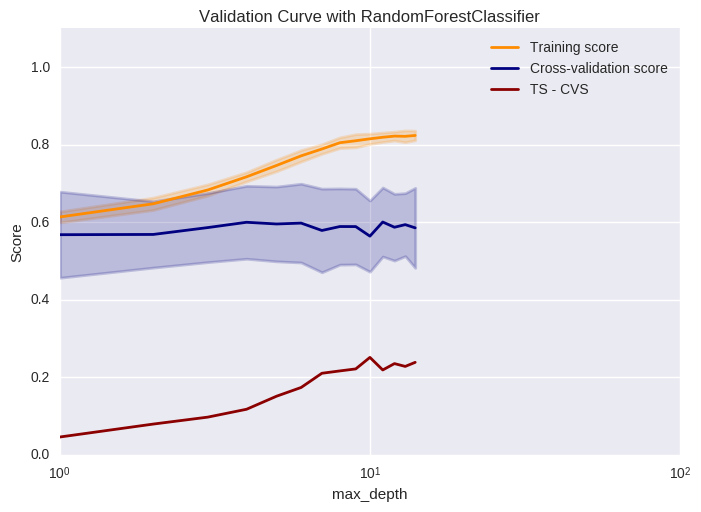

In [116]:
#param_range = np.arange(1,50)
param_range=np.arange(1,15)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(min_samples_leaf=10), X_resampled, Y_resampled, param_name="max_depth", param_range=param_range,
    cv=30, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.semilogx(param_range, train_scores_mean-test_scores_mean, label="TS - CVS",
             color="darkred", lw=lw)

plt.legend(loc="best")
plt.show()

- Here we can see that the max_depth parameer affect significantly the overfitting issue

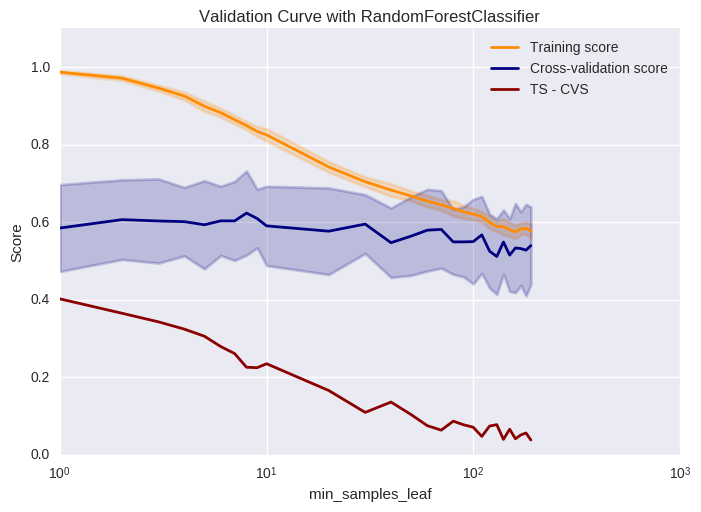

In [117]:
#param_range = np.arange(1,100)
param_range = np.concatenate((np.arange(1,10),np.arange(1,20)*10))
train_scores, test_scores = validation_curve(
    RandomForestClassifier(), X_resampled, Y_resampled, param_name="min_samples_leaf", param_range=param_range,
    cv=30, scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForestClassifier")
plt.xlabel("min_samples_leaf")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.semilogx(param_range, train_scores_mean-test_scores_mean, label="TS - CVS",
             color="darkred", lw=lw)
plt.legend(loc="best")
plt.show()

- We can see that min_samples_leaf parameter affect also the overfitting : small min_samples_leaf values will lead to strong overfit for our dataset
- min_samples_leaf is amoung those 4 parameters the one who affects the most the overfitting

### FITTING THE MODEL WITH THE CROSS VALIDATION RESULTS

- Here we are gonna fit a model with the cross validated parameters
- We are gonna take : max_depth=7 and min_samples_leaf=50

In [118]:
tuned_RFC=RandomForestClassifier(max_depth=7,min_samples_leaf=50,n_estimators=15)

print('Accuracy : ',np.mean(cross_val_score(tuned_RFC,X_resampled,Y_resampled,cv=20,scoring='accuracy')))
print('Precision : ',np.mean(cross_val_score(tuned_RFC,X_resampled,Y_resampled,cv=20,scoring='precision')))
print('Recall : ',np.mean(cross_val_score(tuned_RFC,X_resampled,Y_resampled,cv=20,scoring='recall')))
print('F1-score : ',np.mean(cross_val_score(tuned_RFC,X_resampled,Y_resampled,cv=20,scoring='f1')))
print('ROC AUC : ',np.mean(cross_val_score(tuned_RFC,X_resampled,Y_resampled,cv=20,scoring='roc_auc')))

Accuracy :  0.587828947368
Precision :  0.565302045449
Recall :  0.575657894737
F1-score :  0.558767778551
ROC AUC :  0.598514889197


Confusion matrix, without normalization
[[54 46]
 [39 54]]
Normalized confusion matrix
[[ 0.54  0.46]
 [ 0.42  0.58]]


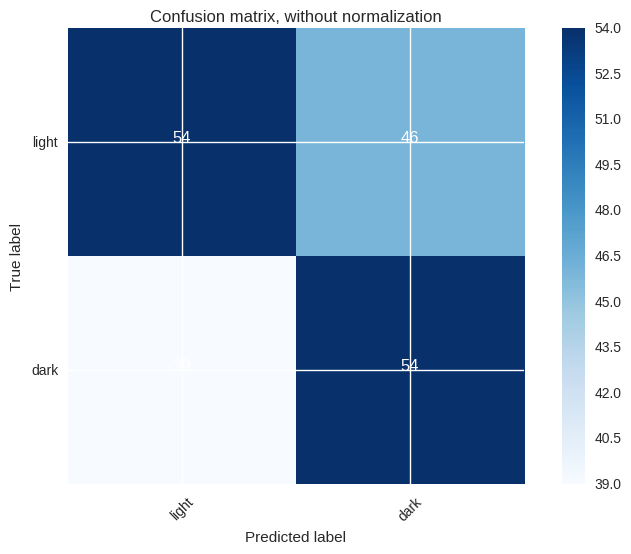

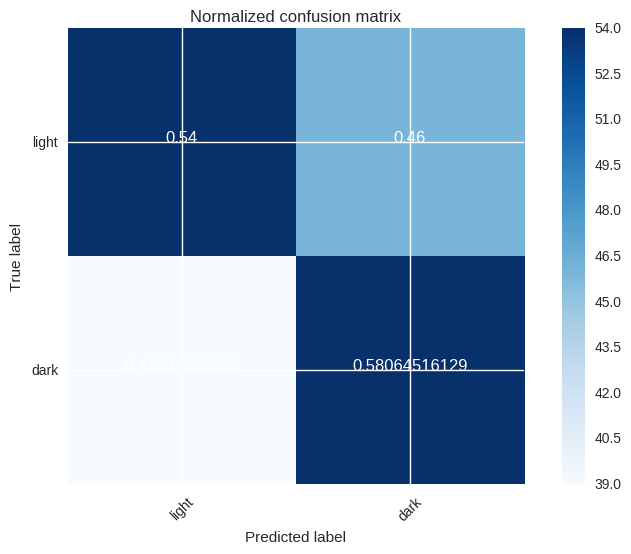

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, random_state=0)
y_pred = tuned_RFC.fit(X_train, y_train).predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names=['light','dark']

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

- we notice a slight improvement in the results

## FEATURE IMPORTANCES

mean accuracy: 0.712987012987
cv score: 0.5925


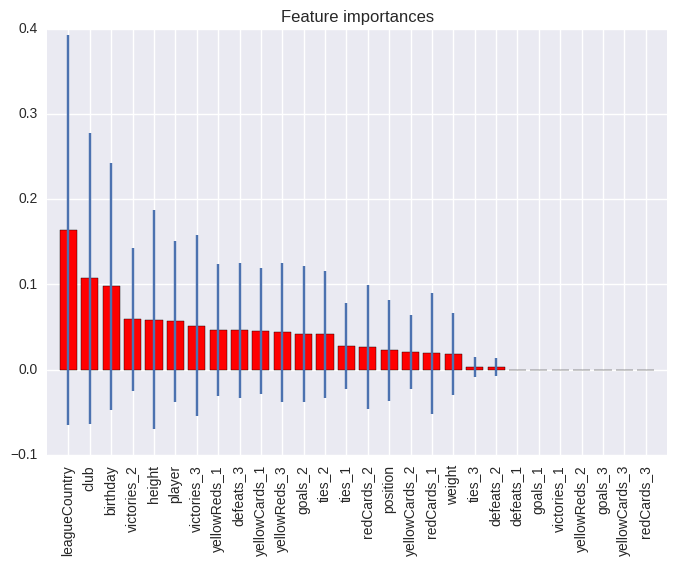

In [120]:
tuned_RFC.fit(X_resampled,Y_resampled)
importances = tuned_RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in tuned_RFC.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('mean accuracy:', tuned_RFC.score(X_resampled,Y_resampled))
print('cv score:', np.mean(cross_val_score(tuned_RFC,X_resampled,Y_resampled,cv=50)))


# plot the feature importances of the random forest
plot_labels = columns[indices]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_resampled.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_resampled.shape[1]), plot_labels, rotation='vertical')
plt.xlim([-1, X_resampled.shape[1]])
plt.show()

- From the plot above, we can see that the most important features are related to the player only.
- We notice that the club and leagueCountry are the most important features
- We noticed that when we fit with the complete data we have much less uncertainty in the feature importance graph.
- Since our solution for dealing with imbalance dataset was to undersample the data, it is natural to have more uncertainty.

mean accuracy: 0.655844155844
cv score: 0.6225


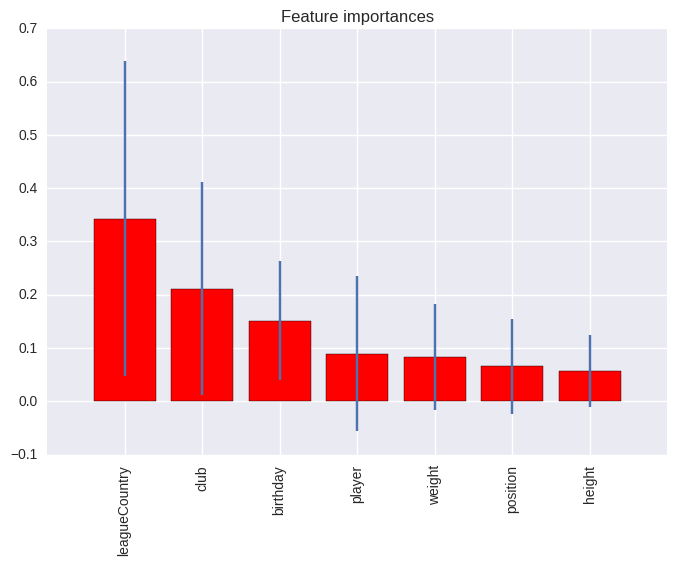

In [121]:
tuned_RFC.fit(X_resampled[:,:7],Y_resampled)
importances = tuned_RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in tuned_RFC.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('mean accuracy:', tuned_RFC.score(X_resampled[:,:7],Y_resampled))
print('cv score:', np.mean(cross_val_score(tuned_RFC,X_resampled[:,:7],Y_resampled,cv=50)))


# plot the feature importances of the random forest
plot_labels = columns[:7][indices]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_resampled[:,:7].shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_resampled[:,:7].shape[1]), plot_labels, rotation='vertical')
plt.xlim([-1, X_resampled[:,:7].shape[1]])
plt.show()

- Beside height, after the removal of referee related features, the importance of features among player-related features doesn't change.
- Also, leagueCountry seems to be the most important feature in our set

mean accuracy: 0.625974025974
cv score: 0.481071428571


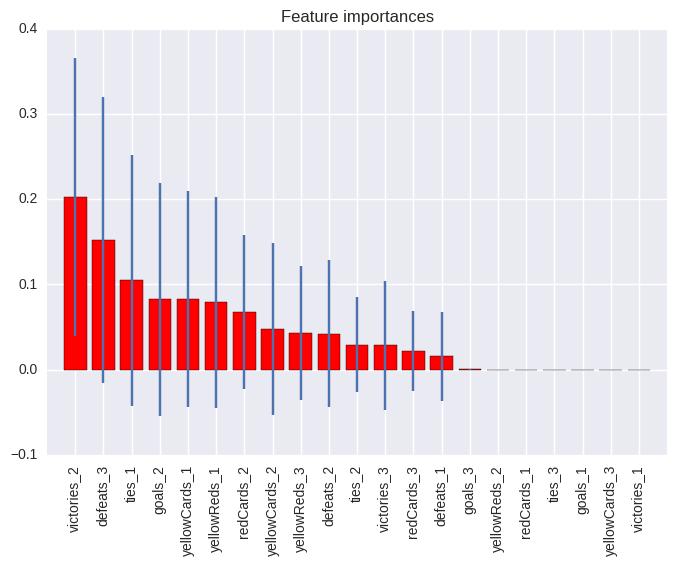

In [122]:
tuned_RFC.fit(X_resampled[:,7:],Y_resampled)
importances = tuned_RFC.feature_importances_
std = np.std([tree.feature_importances_ for tree in tuned_RFC.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print('mean accuracy:', tuned_RFC.score(X_resampled[:,7:],Y_resampled))
print('cv score:', np.mean(cross_val_score(tuned_RFC,X_resampled[:,7:],Y_resampled,cv=50)))


# plot the feature importances of the random forest
plot_labels = columns[7:][indices]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_resampled[:,7:].shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_resampled[:,7:].shape[1]), plot_labels, rotation='vertical')
plt.xlim([-1, X_resampled[:,7:].shape[1]])
plt.show()

## BONUS : LEARNING CURVES

### High bias

- To get a high bias, it's suffiscient to take a big min_samples_leaf, a small max_depth and n_estimator because it leads the model to a lack of learning situation that gives a high bias

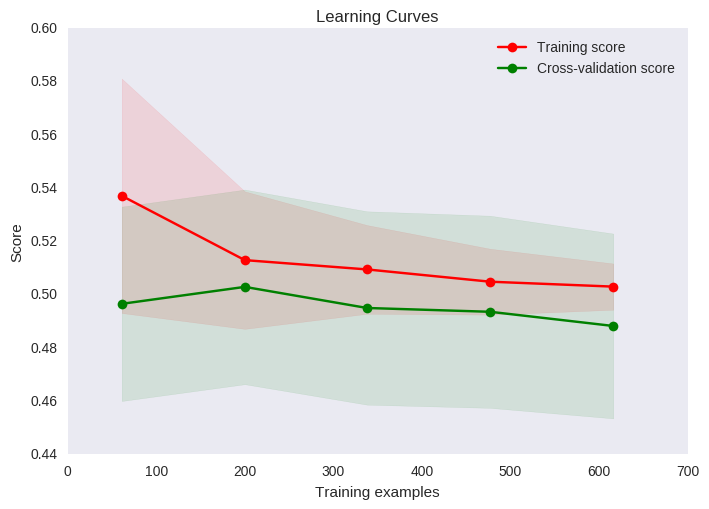

In [123]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


RFC1=RandomForestClassifier(max_depth=1,min_samples_leaf=10000,n_estimators=1)

title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(RFC1, title, X_resampled, Y_resampled, cv=cv, n_jobs=4)

plt.show()

### Low bias

- To get a low bias, we need to have a model that is precise so we have to increase the parameters that influence the most the learning.

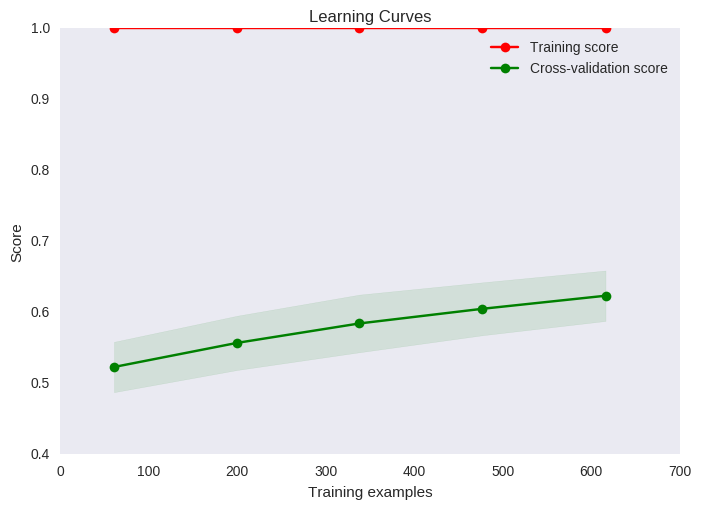

In [124]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


RFC2=RandomForestClassifier(min_samples_leaf=1,n_estimators=200)

title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

plot_learning_curve(RFC2, title, X_resampled, Y_resampled, cv=cv, n_jobs=4)

plt.show()

# Clusteting

- In the Section Below, we will perform an unsupervised learning and try to cluster players in two clusters.
- For that, we will use one clustering method : KMeans

In [125]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### MAXIMIZING SILHOUETTE SCORE WITH KMEANS CLUSTERS

- This algorithm helps us to find at each iteration the feature that we should remove in order to have a better silhouette score with KMeans clustering.
- It displays at each iteration the removed feature, the silhouette score and the f1 score and, at the end, the configuration that gives us the best silhouette score

In [126]:
max_sil=-10
i_max=0
no_i=[]
b=True
iter=0
while b:
    b=False
    for i in np.delete(np.arange(28),no_i):
        subX=np.delete(X,no_i+[i],axis=1)
        kmeans = KMeans(n_clusters=2).fit(subX,Y_true)
        Y_predict=kmeans.labels_
        if silhouette_score(subX,Y_predict)>max_sil:
            max_sil=silhouette_score(subX,Y_predict)
            i_max=i
            b=True
    subX=np.delete(X,no_i+[i_max],axis=1)
    kmeans = KMeans(n_clusters=2).fit(subX,Y_true)
    Y_predict=kmeans.labels_
    if b:
        print('iter ',iter)
        print('removed feature :',columns[i_max])
        print('silhouette score :',max_sil)
        print('f1_score :',max([f1_score(Y_predict,Y_true),f1_score(1-Y_predict,Y_true)]),'\n')
        no_i=no_i+[i_max]
        if len(no_i)==27:
            b=False
    iter=iter+1

print('\nbest silhouette score :', max_sil)
print('used features :', columns[np.delete(np.arange(28),no_i)])

iter  0
removed feature : player
silhouette score : 0.580998492466
f1_score : 0.396946564885 

iter  1
removed feature : position
silhouette score : 0.60114723423
f1_score : 0.396946564885 

iter  2
removed feature : weight
silhouette score : 0.61931485453
f1_score : 0.396946564885 

iter  3
removed feature : height
silhouette score : 0.641280770111
f1_score : 0.395229982964 

iter  4
removed feature : birthday
silhouette score : 0.654324729235
f1_score : 0.396946564885 

iter  5
removed feature : leagueCountry
silhouette score : 0.655497940614
f1_score : 0.395229982964 

iter  6
removed feature : defeats_1
silhouette score : 0.65557360067
f1_score : 0.395229982964 

iter  7
removed feature : ties_2
silhouette score : 0.655640918053
f1_score : 0.395229982964 

iter  8
removed feature : yellowReds_1
silhouette score : 0.65569822952
f1_score : 0.395229982964 

iter  9
removed feature : yellowCards_2
silhouette score : 0.655746348013
f1_score : 0.395229982964 

iter  10
removed feature : 

- We notice that removing a feature helps us to have a better silhouette score at each iteration until only one feature remains.

- We can see that the columns ties_3 has a few values and that the huge majority of its values are the same. So it's normal that it gives us the best silhouette score :

In [127]:
Counter(np.concatenate(X[:,np.delete(np.arange(28),no_i)]))

Counter({0.0: 340,
         0.00041050903119868636: 1243,
         0.068965517241379309: 1,
         0.071428571428571425: 1})

- We can say the same for all the features that we remove at the end after we begin to get too high silhouette scores.

## MAXIMIZING THE SILHOUETTE SCORE OF BLACK/WHITE CLUSTERING

- This algorithm removes at each step the feature that should be removed to have a better silhouette score.
- At each iteration, it displays the removed feature and the silhouette score.
- At the end, it displays the configuration that give us the best silhouette score.

In [128]:
max_sil=-10
i_max=0
no_i=[]
b=True
iter=0
while b:
    b=False
    for i in np.delete(np.arange(28),no_i):
        subX=np.delete(X,no_i+[i],axis=1)
        if silhouette_score(subX,Y_true)>max_sil:
            max_sil=silhouette_score(subX,Y_true)
            i_max=i
            b=True
    subX=np.delete(X,no_i+[i_max],axis=1)
    if b:
        print('iter ',iter)
        print('removed feature :',columns[i_max])
        print('silhouette score :',max_sil,'\n')
        no_i=no_i+[i_max]
        if len(no_i)==27:
            b=False
    iter=iter+1

print('\nbest silhouette score :', max_sil)
print('used features :', columns[np.delete(np.arange(28),no_i)])

iter  0
removed feature : player
silhouette score : -0.0147997130501 

iter  1
removed feature : club
silhouette score : 0.00130075093849 

iter  2
removed feature : height
silhouette score : 0.00605253659633 

iter  3
removed feature : birthday
silhouette score : 0.0110023190623 

iter  4
removed feature : weight
silhouette score : 0.0180124853822 

iter  5
removed feature : leagueCountry
silhouette score : 0.0227762695349 

iter  6
removed feature : defeats_1
silhouette score : 0.0228800283239 

iter  7
removed feature : yellowReds_1
silhouette score : 0.022958793891 

iter  8
removed feature : ties_2
silhouette score : 0.0230301419853 

iter  9
removed feature : victories_1
silhouette score : 0.023102078079 

iter  10
removed feature : redCards_1
silhouette score : 0.023171983127 

iter  11
removed feature : position
silhouette score : 0.0240645514839 

iter  12
removed feature : goals_1
silhouette score : 0.0289054944384 

iter  13
removed feature : ties_1
silhouette score : 0.0328

- The best silhouette score that we could obtain with the black/white clustering is 0.146. It's too low. 
- We don't think we can obtain a really high silhouette score with this clustering even if we consider all the possible configurations of features.